# FIN 514 - Project 2 - Product 1, SPX
**Spring '22**

This notebook provides the valuation of Product 1 of Project 2 for FIN 514, Spring 2022
## Packages and Configurations

The following common packages will be use on this notebook.

* numpy - [https://numpy.org/](https://numpy.org/)
* Pandas - [https://pandas.pydata.org/](https://pandas.pydata.org/)
* matplotlib - [https://matplotlib.org/](https://matplotlib.org/)
* Scipy Statistical functions - [https://docs.scipy.org/doc/scipy/reference/stats.html](https://docs.scipy.org/doc/scipy/reference/stats.html)


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
# ENTER INPUTS FOR STOCK

N = 546
T1 = 546/365
T2 = 549/365
S0 = 4577.11
Barrier = 0.7*S0
#r1 goes to valuation for stock price movements
r1 = 0.0075550
#r2 goes to maturity for discounting
r2 = 0.0075934
q = 0.014536
#Put in all vols from 70% moneyness to ATM for sensitivity
vol = np.zeros([8])
vol[1] = 0.30685
vol[2] = 0.2911
vol[3] = 0.27622
vol[4] = 0.26189
vol[5] = 0.24712
vol[6] = 0.2159


In [3]:
# Enter key dates for product
Face = 1000 
NC = 12
Coupon_rate = 0.0645
Cpn = Face*Coupon_rate/NC
#Coupon only dates
tco = [37/365, 64/365]
tcop = [37/365, 64/365]
#Call and coupon dats
tac = [90/365,120/365,154/365,181/365,212/365,243/365,273/365,304/365,334/365,365/365,399/365,426/365,455/365,485/365,518/365]
tacp = [93/365,125/365,157/365,184/365,217/365,247/365,276/365,309/365,338/365,370/365,402/365,429/365,458/365,490/365,521/365]
#all payment dates
tp = [37/365, 64/365,93/365,125/365,157/365,184/365,217/365,247/365,276/365,309/365,338/365,370/365,402/365,429/365,458/365,490/365,521/365]

In [4]:
# ENTER INPUT FOR: start_step

#jmax = 100 #Number of S steps
imax = 30*N #Number of t steps
maxjmax = np.sqrt(imax/(T1*vol[1]**2))
jmax = 250
SL = 0 #Minimum S value
SU = 2.5*S0 #Maximum S value

In [5]:
maxjmax
Cpn

5.375

In [10]:
def EXPFD_model(S0, Barrier, T1, T2, r1, r2, q, sigma, SU, jmax, imax, Cpn, Face, tco, tcop, tac, tacp, tp):
    
    #LIST TO SAVE RESULTS
    #Assumes that SL= 0, can be relaxed, see notes for updates A, B, C values in this case
    
    expfd_result = []
    print(sigma)
    #for jmax in range(jmaxmin, jmaxmax, jmaxstep): 
    
    # CREATE twp TWO DIMENSIONAL ARRAY OF SIZE [imax+1,jmax+1] TO STORE V AT ALL STEPS
    # V[imax, jmax]
    
    V = np.zeros([imax+1, jmax+1])
    VT = np.zeros([imax+1, jmax+1])

    # CREATE ONE DIMENSIONAL ARRAY OF SIZE [jmax+1] TO STORE A, B, C VALUES AT ALL STEPS
    # A[jmax], B[jmax], C[jmax] 
    
    A = np.zeros([jmax+1])
    B = np.zeros([jmax+1])
    C = np.zeros([jmax+1])
    
    # Set up time and S steps and key values of i and j
    
    dt = T1 / imax
    dS = SU/jmax
        
    jb = round(Barrier/dS)
    print(jb)
       
    ico1 = [i/dt for i in tco]
    ico = [int(i) for i in ico1]

    iac1 = [i/dt for i in tac]
    iac = [int(i) for i in iac1]
    
    ip1 = [i/dt for i in tp]
    ip = [int(i) for i in ip1]
    
    print(ico,iac,ip)
        
    # We start with the VT code and then use the values on the boundary to solve for V
    
    i = imax 
        
    for j in range(0, jmax+1):    
    # Get the value at maturity for VT
    # Also calculate the probabilities A, B, C

        VT[i, j] = (Face+Cpn)*np.exp(-r2*(T2-T1))
        if j*dS < S0:
            VT[i, j] = (Face*j*dS/S0+Cpn)*np.exp(-r2*(T2-T1))
       
        A[j] = (0.5 * (sigma ** 2) * (j ** 2) + 0.5 * (r1 - q) * j) * dt
        B[j] =  1 - r2 * dt - sigma ** 2 * j ** 2 * dt
        C[j] = (0.5 * (sigma ** 2) * (j ** 2) - 0.5 * (r1 - q) * j) * dt
        
    #Now go back in time, keeping track of the next autoicall date
    
    #inc here is number of call dats, inp is number of payment dates
    inac = len(iac)
    inp = len(ip)
    maxip = len(ip)
    print(inac,inp,maxip)
    #nc here is nearest call date
    nac = T2
         
    
    for i in range(imax-1, -1, -1):
       #Figuring out the next call date
        if tacp[inac-1] >= i*dt:
            if inac > 0:
                inac = inac - 1
                nac = tacp[inac]
            else: 
                inac = 0
                nac = tacp[inac]
        if tp[inp-1] >= i*dt:
            if inp > 0:
                inp = inp - 1
            else: 
                inp = 0       
        
        #Figuring out lower boundary condition
        VT[i, 0] = Cpn*np.exp(-r2*(T2-i*dt))
        for k in range(inp,maxip):
            VT[i, 0] += Cpn*np.exp(-r2*(tp[k]-i*dt))

         
            
        #regular finite difference formula
        for j in range(1, jmax, 1):

            VT[i,j] = A[j]*VT[i+1,j+1]+B[j]*VT[i+1,j]+C[j]*VT[i+1,j-1]
            if i in ico: VT[i,j] += Cpn*np.exp(-r2*(tcop[ico.index(i)]-i*dt))
            if i in iac:
                if j*dS >= S0: Face*np.exp(-r2*(tacp[iac.index(i)]-i*dt))    
                VT[i,j] += Cpn*np.exp(-r2*(tacp[iac.index(i)]-i*dt))
        
        VT[i,jmax]=(Face+Cpn)*np.exp(-r2*(nac-i*dt))
    
    print(VT[5*546,jb]) 
            
    i = imax  
    for j in range(jb, jmax+1):    
  
           
        V[i, j] = (Face+Cpn)*np.exp(-r2*(T2-T1))
        A[j] = (0.5 * (sigma ** 2) * (j ** 2) + 0.5 * (r1 - q) * j) * dt
        B[j] =  1 - r2 * dt - sigma ** 2 * j ** 2 * dt
        C[j] = (0.5 * (sigma ** 2) * (j ** 2) - 0.5 * (r1 - q) * j) * dt

        #print(j,V[i,j])    
    inc = len(iac)
    nc = T2
    
    for i in range(imax-1, -1, -1):
        if tacp[inac-1] >= i*dt:
            if inac > 0:
                inac = inac - 1
                nac = tacp[inac]
            else: 
                inac = 0
                nac = tacp[inac]

        #Lower boundary condition
        V[i, jb] = VT[i, jb]
        #print(i,jb,V[i,jb])
        
        #regular finite difference formula
        for j in range(jb+1, jmax, 1):

            V[i,j] = A[j]*V[i+1,j+1]+B[j]*V[i+1,j]+C[j]*V[i+1,j-1]
            if i in ico: V[i,j] += Cpn*np.exp(-r2*(tcop[ico.index(i)]-i*dt))
            if i in iac:
                if j*dS >= S0: V[i,j] = (Face)*np.exp(-r2*(tacp[iac.index(i)]-i*dt))    
                V[i,j] += Cpn*np.exp(-r2*(tacp[iac.index(i)]-i*dt))
        
        V[i,jmax]=(Face+Cpn)*np.exp(-r2*(nac-i*dt))
            
    # RELAY OUTPUTS TO DICTIONARY
    jcritreal = S0/dS
    jcrit = int(jcritreal)
    Vcrit = V[0,jcrit]+ (S0 - jcrit * dS) / (dS) * (V[0,jcrit+1] - V[0,jcrit])
    output = {'S_steps': jmax, 't_steps': imax, 'EXP': Vcrit}
    expfd_result.append(output)

    return expfd_result

In [11]:
expfd = EXPFD_model(S0, Barrier, T1, T2, r1, r2, q, vol[6], SU, jmax, imax, Cpn, Face, tco, tcop, tac, tacp, tp)

0.2159
70
[1110, 1920] [2700, 3599, 4620, 5430, 6359, 7290, 8190, 9120, 10020, 10950, 11970, 12780, 13650, 14550, 15539] [1110, 1920, 2790, 3749, 4710, 5520, 6510, 7410, 8280, 9270, 10140, 11100, 12059, 12869, 13740, 14700, 15630]
15 17 17
761.975605201928


In [12]:
df = pd.DataFrame.from_dict(expfd)
df

,S_steps,t_steps,EXP
0,250,16380,991.19394


In [36]:
# ENTER INPUT FOR: start_step

#jmax = 100 #Number of S steps
imax = 10*N #Number of t steps
jmaxmin = 250
jmaxmax = 2500
jmaxstep = 250
SL = 0 #Minimum S value
SU = 2.5*S0 #Maximum S value

In [37]:

def CNFD_model(S0, Barrier, T1, T2, r1, r2, q, sigma, SU, jmaxmin, jmaxmax, jmaxstep, imax, Cpn, Face, tco, tcop, tac, tacp, tp):
    
    #LIST TO SAVE RESULTS
    #Assumes that SL= 0, can be relaxed, see notes for updates A, B, C values in this case
    
    cnfdb_result = []
    
    for jmax in range(jmaxmin, jmaxmax, jmaxstep): 
    
        V = np.zeros([imax+1, jmax+1])
        VT = np.zeros([imax+1, jmax+1])

        # CREATE ONE DIMENSIONAL ARRAY OF SIZE [jmax+1] TO STORE A, B, C VALUES AT ALL STEPS
        # A[jmax], B[jmax], C[jmax] 

        A = np.zeros([jmax+1])
        B = np.zeros([jmax+1])
        C = np.zeros([jmax+1])
        D = np.zeros([jmax+1])
        alpha = np.zeros([jmax+1])
        CN_S = np.zeros([jmax+1])
        Vboundary = np.zeros([imax+1])

        # Set up time and S steps and key values of i and j

        dt = T1 / imax
        dS = SU/jmax

        jb = round(Barrier/dS)
        j0 = round(S0/dS)
        print(jb,j0)   

        ico1 = [i/dt for i in tco]
        ico = [int(i) for i in ico1]

        iac1 = [i/dt for i in tac]
        iac = [int(i) for i in iac1]
    
        ip1 = [i/dt for i in tp]
        ip = [int(i) for i in ip1]
    
        #print(ico,tco,ic,tc,ip,tp)

        # CALCULATE OPTION VALUES AND PROBABILITIES
        # Start at the last step number because we are going to be moving backwards from times step imax to times step 0

    ## VT CODE STARTS HERE

        i = imax 

        for j in range(0, jmax+1):    
        # Get the value at maturity for VT
        # Also calculate the probabilities A, B, C

            VT[i, j] = (Face+Cpn)*np.exp(-r2*(T2-T1))
            if j*dS < S0:
                VT[i, j] = (Face*j*dS/S0+Cpn)*np.exp(-r2*(T2-T1))

            #Now go back in time, keeping track of the next autoicall date
        inac = len(iac)
        inp = len(ip)
        maxip = len(ip)
        print(inac,inp,maxip)
        #nc here is nearest call date
        nac = T2      

        #Now go back in time
        for i in range(imax-1, -1, -1):
            if tacp[inac-1] >= i*dt:
                if inac > 0:
                    inac = inac - 1
                    nac = tacp[inac]
                else: 
                    inac = 0
                    nac = tacp[inac]
            if tp[inp-1] >= i*dt:
                if inp > 0:
                    inp = inp - 1
                else: 
                    inp = 0       
        
            #Figuring out lower boundary condition
            LBC = Cpn*np.exp(-r2*(T2-i*dt))
            for k in range(inp,maxip):
                LBC += Cpn*np.exp(-r2*(tp[k]-i*dt))

            if i in iac:

                #Lower boundary condition in matrix terms
                A[0] = 0
                B[0] = 1
                C[0] = 0
                D[0] = LBC

                for j in range(1, j0):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
                    B[j] = -1/dt-0.5*r2-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j
                    D1 = -VT[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                    D2 = -VT[i+1,j]*(1/dt-0.5*r2-0.5*sigma**2*j**2)
                    D3 = -VT[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                    D[j] = D1+D2+D3

                #Upper boundary condition in matrix terms
                A[j0] = 0
                B[j0] = 1
                C[j0] = 0
                D[j0] = (Face)*np.exp(-r2*(tacp[iac.index(i)]-i*dt)) 

                alpha[0] = B[0]
                CN_S[0] = D[0]
                for j in range(1, j0+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                VT[i,j0] = CN_S[j0]/alpha[j0]
                for j in range(j0-1,-1,-1):
                    VT[i,j] = (CN_S[j]-C[j]*VT[i,j+1])/alpha[j]

                Vboundary[i] = VT[i,jb]

                for j in range(j0+1,jmax+1):
                    VT[i,j] = (Face+Cpn)*np.exp(-r2*(tacp[iac.index(i)]-i*dt)) 

                for j in range(1,j0):
                    VT[i,j] += Cpn*np.exp(-r2*(tacp[iac.index(i)]-i*dt)) 

            else:

                A[0] = 0
                B[0] = 1
                C[0] = 0
                D[0] = LBC

                for j in range(1, jmax):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
                    B[j] = -1/dt-0.5*r2-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j
                    D1 = -VT[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                    D2 = -VT[i+1,j]*(1/dt-0.5*r2-0.5*sigma**2*j**2)
                    D3 = -VT[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                    D[j] = D1+D2+D3

                #Upper boundary condition in matrix terms
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                D[jmax] = (Face+Cpn)*np.exp(-r2*(nac-i*dt))

                alpha[0] = B[0]
                CN_S[0] = D[0]
                for j in range(1, jmax+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                VT[i,jmax] = CN_S[jmax]/alpha[jmax]
                for j in range(jmax-1,-1,-1):
                    VT[i,j] = (CN_S[j]-C[j]*VT[i,j+1])/alpha[j]

                Vboundary[i] = VT[i,jb]  

                if i in ico:

                    for j in range(0,jmax):
                        VT[i,j] += Cpn*np.exp(-r2*(tcop[ico.index(i)]-i*dt)) 


    ## V CODE STARTS HERE

        i = imax 

        for j in range(jb, jmax+1):    
        # Get the value at maturity for VT
        # Also calculate the probabilities A, B, C

             V[i, j] = (Face+Cpn)*np.exp(-r2*(T2-T1))

        inc = len(iac)
        nac = T2         

        #Now go back in time
        for i in range(imax-1, -1, -1):
            if tacp[inac-1] >= i*dt:
                if inac > 0:
                    inac = inac - 1
                    nac = tacp[inac]
                else: 
                    inac = 0
                    nac = tacp[inac]

            if i in iac:

                #Lower boundary condition in matrix terms
                A[jb] = 0
                B[jb] = 1
                C[jb] = 0
                D[jb] = Vboundary[i]

                for j in range(jb+1, j0):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
                    B[j] = -1/dt-0.5*r2-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j
                    D1 = -V[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                    D2 = -V[i+1,j]*(1/dt-0.5*r2-0.5*sigma**2*j**2)
                    D3 = -V[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                    D[j] = D1+D2+D3

                #Upper boundary condition in matrix terms
                A[j0] = 0
                B[j0] = 1
                C[j0] = 0
                D[j0] = (Face)*np.exp(-r2*(tacp[iac.index(i)]-i*dt))

                alpha[jb] = B[jb]
                CN_S[jb] = D[jb]
                for j in range(jb+1, j0+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                V[i,j0] = CN_S[j0]/alpha[j0]
                for j in range(j0-1,jb-1,-1):
                    V[i,j] = (CN_S[j]-C[j]*V[i,j+1])/alpha[j]

                for j in range(j0+1,jmax+1):
                    V[i,j] = (Face+Cpn)*np.exp(-r2*(tacp[iac.index(i)]-i*dt))

                for j in range(jb+1,j0):
                    V[i,j] += Cpn*np.exp(-r2*(tacp[iac.index(i)]-i*dt))

            else:

                A[jb] = 0
                B[jb] = 1
                C[jb] = 0
                D[jb] = Vboundary[i]

                for j in range(jb+1, jmax):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
                    B[j] = -1/dt-0.5*r2-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j
                    D1 = -V[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                    D2 = -V[i+1,j]*(1/dt-0.5*r2-0.5*sigma**2*j**2)
                    D3 = -V[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                    D[j] = D1+D2+D3

                #Upper boundary condition in matrix terms
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                D[jmax] = (Face+Cpn)*np.exp(-r2*(nac-i*dt))

                alpha[jb] = B[jb]
                CN_S[jb] = D[jb]
                for j in range(jb+1, jmax+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                V[i,jmax] = CN_S[jmax]/alpha[jmax]
                for j in range(jmax-1,jb-1,-1):
                    V[i,j] = (CN_S[j]-C[j]*V[i,j+1])/alpha[j]

                if i in ico:

                    for j in range(jb+1,jmax):
                        V[i,j] += Cpn*np.exp(-r2*(tcop[ico.index(i)]-i*dt))
            
        # RELAY OUTPUTS TO DICTIONARY
        jcritreal = S0/dS
        jcrit = int(jcritreal)
        jcritB = int(Barrier/dS)+1
        Vcrit = V[0,jcrit]+ (S0 - jcrit * dS) / (dS) * (V[0,jcrit+1] - V[0,jcrit])
        Blambda = (jcritB*dS - Barrier)/dS
        output = {'S_steps': jmax, 't_steps': imax, 'CN': Vcrit, 'Barrier Lambda': Blambda}
        cnfdb_result.append(output)

    return cnfdb_result


In [38]:
cnfd = CNFD_model(S0, Barrier, T1, T2, r1, r2, q, vol[6], SU, jmaxmin, jmaxmax, jmaxstep, imax, Cpn, Face, tco, tcop, tac, tacp, tp)

70 100
15 17 17
140 200
15 17 17
210 300
15 17 17
280 400
15 17 17
350 500
15 17 17
420 600
15 17 17
490 700
15 17 17
560 800
15 17 17
630 900
15 17 17


In [39]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df = pd.DataFrame.from_dict(cnfd)

In [40]:

df

,S_steps,t_steps,CN,Barrier Lambda
0,250,5460,990.771148,9.935251e-15
1,500,5460,990.917498,1.987050e-14
2,750,5460,990.976032,2.980575e-14
3,1000,5460,991.008229,3.974100e-14
4,1250,5460,991.028766,9.935251e-14
5,1500,5460,991.043047,5.961150e-14
6,1750,5460,991.053564,6.954675e-14
7,2000,5460,991.061634,7.948201e-14
8,2250,5460,991.068023,8.941726e-14


In [21]:
# EXPORT THE DATA TO A CSV FILE
df.to_csv("Data/Proj2_cn.csv", index=False)

CN finite difference error profile with lamba ideally at 0/1 to ensure the continuous barrier is on a layer of grid points. Notice that when the barrier switches to the wrong node we see the nonlinearity error appear! These values are for the 100% moneyness volatilities

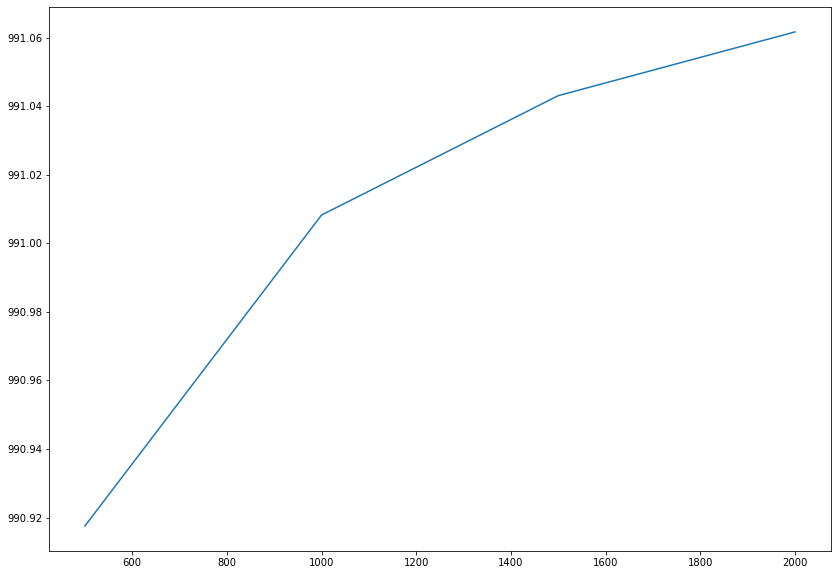

In [22]:
plt.figure(figsize=(14,10))
plt.plot(df['S_steps'], df['CN'], '-', markersize=3)
plt.savefig('Images/Proj2_prod1.png')
plt.show()

In [23]:
# EXPORT THE DATA TO A CSV FILE
df.to_csv("Data/Proj2_prod1.csv", index=False)

With large number of S and T steps how does this change with volatility?

In [30]:

def CNFD_vol(S0, Barrier, T1, T2, r1, r2, q, vol, SU, jmax, imax, Cpn, Face, tco, tcop, tac, tacp, tp):
    
    #LIST TO SAVE RESULTS
    #Assumes that SL= 0, can be relaxed, see notes for updates A, B, C values in this case
    
    cnfdb_result = []
    
    for k in range(1, 7): 
    
        sigma = vol[k]
        print (sigma)
        V = np.zeros([imax+1, jmax+1])
        VT = np.zeros([imax+1, jmax+1])

        # CREATE ONE DIMENSIONAL ARRAY OF SIZE [jmax+1] TO STORE A, B, C VALUES AT ALL STEPS
        # A[jmax], B[jmax], C[jmax] 

        A = np.zeros([jmax+1])
        B = np.zeros([jmax+1])
        C = np.zeros([jmax+1])
        D = np.zeros([jmax+1])
        alpha = np.zeros([jmax+1])
        CN_S = np.zeros([jmax+1])
        Vboundary = np.zeros([imax+1])

        # Set up time and S steps and key values of i and j

        dt = T1 / imax
        dS = SU/jmax

        jb = round(Barrier/dS)
        j0 = round(S0/dS)
        print(jb,j0)   

        ico1 = [i/dt for i in tco]
        ico = [int(i) for i in ico1]

        iac1 = [i/dt for i in tac]
        iac = [int(i) for i in iac1]
    
        ip1 = [i/dt for i in tp]
        ip = [int(i) for i in ip1]
    
        #print(ico,tco,ic,tc,ip,tp)

        # CALCULATE OPTION VALUES AND PROBABILITIES
        # Start at the last step number because we are going to be moving backwards from times step imax to times step 0

    ## VT CODE STARTS HERE

        i = imax 

        for j in range(0, jmax+1):    
        # Get the value at maturity for VT
        # Also calculate the probabilities A, B, C

            VT[i, j] = (Face+Cpn)*np.exp(-r2*(T2-T1))
            if j*dS < S0:
                VT[i, j] = (Face*j*dS/S0+Cpn)*np.exp(-r2*(T2-T1))

            #Now go back in time, keeping track of the next autoicall date
        inac = len(iac)
        inp = len(ip)
        maxip = len(ip)
        print(inac,inp,maxip)
        #nc here is nearest call date
        nac = T2      

        #Now go back in time
        for i in range(imax-1, -1, -1):
            if tacp[inac-1] >= i*dt:
                if inac > 0:
                    inac = inac - 1
                    nac = tacp[inac]
                else: 
                    inac = 0
                    nac = tacp[inac]
            if tp[inp-1] >= i*dt:
                if inp > 0:
                    inp = inp - 1
                else: 
                    inp = 0       
        
            #Figuring out lower boundary condition
            LBC = Cpn*np.exp(-r2*(T2-i*dt))
            for k in range(inp,maxip):
                LBC += Cpn*np.exp(-r2*(tp[k]-i*dt))

            if i in iac:

                #Lower boundary condition in matrix terms
                A[0] = 0
                B[0] = 1
                C[0] = 0
                D[0] = LBC

                for j in range(1, j0):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
                    B[j] = -1/dt-0.5*r2-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j
                    D1 = -VT[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                    D2 = -VT[i+1,j]*(1/dt-0.5*r2-0.5*sigma**2*j**2)
                    D3 = -VT[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                    D[j] = D1+D2+D3

                #Upper boundary condition in matrix terms
                A[j0] = 0
                B[j0] = 1
                C[j0] = 0
                D[j0] = (Face)*np.exp(-r2*(tacp[iac.index(i)]-i*dt)) 

                alpha[0] = B[0]
                CN_S[0] = D[0]
                for j in range(1, j0+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                VT[i,j0] = CN_S[j0]/alpha[j0]
                for j in range(j0-1,-1,-1):
                    VT[i,j] = (CN_S[j]-C[j]*VT[i,j+1])/alpha[j]

                Vboundary[i] = VT[i,jb]

                for j in range(j0+1,jmax+1):
                    VT[i,j] = (Face+Cpn)*np.exp(-r2*(tacp[iac.index(i)]-i*dt)) 

                for j in range(1,j0):
                    VT[i,j] += Cpn*np.exp(-r2*(tacp[iac.index(i)]-i*dt)) 

            else:

                A[0] = 0
                B[0] = 1
                C[0] = 0
                D[0] = LBC

                for j in range(1, jmax):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
                    B[j] = -1/dt-0.5*r2-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j
                    D1 = -VT[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                    D2 = -VT[i+1,j]*(1/dt-0.5*r2-0.5*sigma**2*j**2)
                    D3 = -VT[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                    D[j] = D1+D2+D3

                #Upper boundary condition in matrix terms
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                D[jmax] = (Face+Cpn)*np.exp(-r2*(nac-i*dt))

                alpha[0] = B[0]
                CN_S[0] = D[0]
                for j in range(1, jmax+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                VT[i,jmax] = CN_S[jmax]/alpha[jmax]
                for j in range(jmax-1,-1,-1):
                    VT[i,j] = (CN_S[j]-C[j]*VT[i,j+1])/alpha[j]

                Vboundary[i] = VT[i,jb]  

                if i in ico:

                    for j in range(0,jmax):
                        VT[i,j] += Cpn*np.exp(-r2*(tcop[ico.index(i)]-i*dt)) 


    ## V CODE STARTS HERE

        i = imax 

        for j in range(jb, jmax+1):    
        # Get the value at maturity for VT
        # Also calculate the probabilities A, B, C

             V[i, j] = (Face+Cpn)*np.exp(-r2*(T2-T1))

        inc = len(iac)
        nac = T2         

        #Now go back in time
        for i in range(imax-1, -1, -1):
            if tacp[inac-1] >= i*dt:
                if inac > 0:
                    inac = inac - 1
                    nac = tacp[inac]
                else: 
                    inac = 0
                    nac = tacp[inac]

            if i in iac:

                #Lower boundary condition in matrix terms
                A[jb] = 0
                B[jb] = 1
                C[jb] = 0
                D[jb] = Vboundary[i]

                for j in range(jb+1, j0):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
                    B[j] = -1/dt-0.5*r2-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j
                    D1 = -V[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                    D2 = -V[i+1,j]*(1/dt-0.5*r2-0.5*sigma**2*j**2)
                    D3 = -V[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                    D[j] = D1+D2+D3

                #Upper boundary condition in matrix terms
                A[j0] = 0
                B[j0] = 1
                C[j0] = 0
                D[j0] = (Face)*np.exp(-r2*(tacp[iac.index(i)]-i*dt))

                alpha[jb] = B[jb]
                CN_S[jb] = D[jb]
                for j in range(jb+1, j0+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                V[i,j0] = CN_S[j0]/alpha[j0]
                for j in range(j0-1,jb-1,-1):
                    V[i,j] = (CN_S[j]-C[j]*V[i,j+1])/alpha[j]

                for j in range(j0+1,jmax+1):
                    V[i,j] = (Face+Cpn)*np.exp(-r2*(tacp[iac.index(i)]-i*dt))

                for j in range(jb+1,j0):
                    V[i,j] += Cpn*np.exp(-r2*(tacp[iac.index(i)]-i*dt))

            else:

                A[jb] = 0
                B[jb] = 1
                C[jb] = 0
                D[jb] = Vboundary[i]

                for j in range(jb+1, jmax):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
                    B[j] = -1/dt-0.5*r2-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j
                    D1 = -V[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                    D2 = -V[i+1,j]*(1/dt-0.5*r2-0.5*sigma**2*j**2)
                    D3 = -V[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                    D[j] = D1+D2+D3

                #Upper boundary condition in matrix terms
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                D[jmax] = (Face+Cpn)*np.exp(-r2*(nac-i*dt))

                alpha[jb] = B[jb]
                CN_S[jb] = D[jb]
                for j in range(jb+1, jmax+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                V[i,jmax] = CN_S[jmax]/alpha[jmax]
                for j in range(jmax-1,jb-1,-1):
                    V[i,j] = (CN_S[j]-C[j]*V[i,j+1])/alpha[j]

                if i in ico:

                    for j in range(jb+1,jmax):
                        V[i,j] += Cpn*np.exp(-r2*(tcop[ico.index(i)]-i*dt))
            
        # RELAY OUTPUTS TO DICTIONARY
        jcritreal = S0/dS
        jcrit = int(jcritreal)
        jcritB = int(Barrier/dS)+1
        Vcrit = V[0,jcrit]+ (S0 - jcrit * dS) / (dS) * (V[0,jcrit+1] - V[0,jcrit])
        Blambda = (jcritB*dS - Barrier)/dS
        output = {'vol count': k, 'vol': sigma, 'CN': Vcrit}
        cnfdb_result.append(output)

    return cnfdb_result


In [31]:
cnfdvol = CNFD_vol(S0, Barrier, T1, T2, r1, r2, q, vol, SU, 2500, 10*N, Cpn, Face, tco, tcop, tac, tacp, tp)

0.30685
700 1000
15 17 17
0.2911
700 1000
15 17 17
0.27622
700 1000
15 17 17
0.26189
700 1000
15 17 17
0.24712
700 1000
15 17 17
0.2159
700 1000
15 17 17


In [32]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df = pd.DataFrame.from_dict(cnfdvol)

In [33]:

df

,vol count,vol,CN
0,16,0.30685,960.301705
1,16,0.29110,964.866975
2,16,0.27622,969.419744
3,16,0.26189,974.065256
4,16,0.24712,979.160131
5,16,0.21590,991.073206


In [34]:
# EXPORT THE DATA TO A CSV FILE
df.to_csv("Data/Proj2_cn_vol.csv", index=False)

CN finite difference error profile with lamba kept at 0/1but different vols 

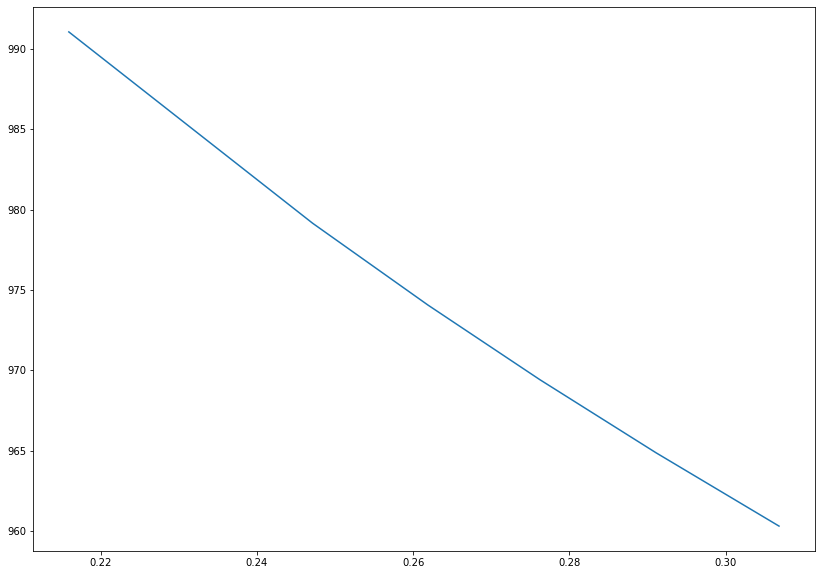

In [35]:
plt.figure(figsize=(14,10))
plt.plot(df['vol'], df['CN'], '-', markersize=3)
plt.savefig('Images/Proj2_prod2_vol.png')
plt.show()

Now what is the volatility implied by the quoted price ($983.00). How does this fit in with our data?

In [49]:
vol1 = np.zeros([7])
vol1[1] = 0.236
vol1[2] = 0.2365
vol1[3] = 0.237
vol1[4] = 0.2375
vol1[5] = 0.238
vol1[6] = 0.238

In [50]:
cnfdvol = CNFD_vol(S0, Barrier, T1, T2, r1, r2, q, vol1, SU, 2000, 3*N, Cpn, Face, tco, tcop, tac, tacp, tp)

0.236
560 800
15 17 17
0.2365
560 800
15 17 17
0.237
560 800
15 17 17
0.2375
560 800
15 17 17
0.238
560 800
15 17 17
0.238
560 800
15 17 17


In [51]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df = pd.DataFrame.from_dict(cnfdvol)

In [52]:

df

,vol count,vol,CN
0,16,0.2360,983.378558
1,16,0.2365,983.193924
2,16,0.2370,983.009699
3,16,0.2375,982.825882
4,16,0.2380,982.642473
5,16,0.2380,982.642473


In [46]:
# EXPORT THE DATA TO A CSV FILE
df.to_csv("Data/Proj2_cn_vol2.csv", index=False)

It looks like the implied volatility is 23.70%. This is in between our resonable range, but closer the the value from ATM volatilities than the barrier volatility. I think my estimate would be slightly lower but $983 is certainly in the reasonable area.

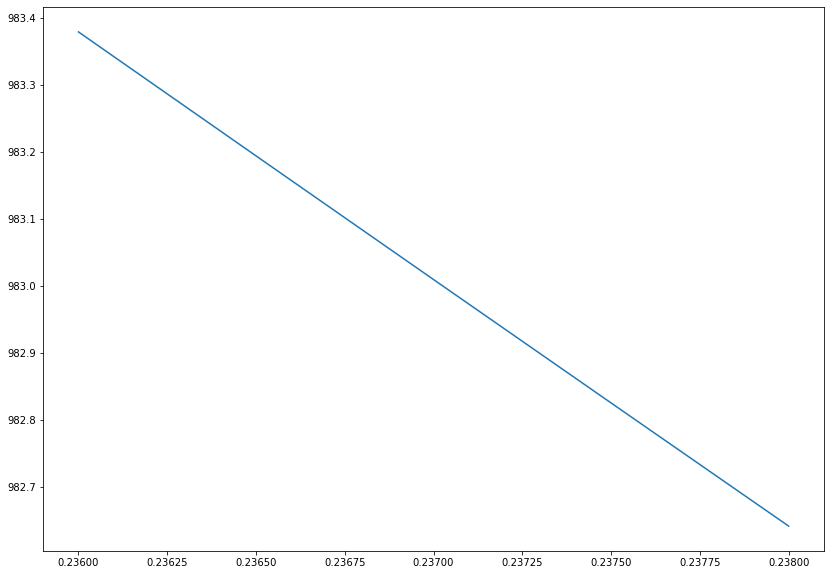

In [53]:
plt.figure(figsize=(14,10))
plt.plot(df['vol'], df['CN'], '-', markersize=3)
plt.savefig('Images/Proj2_prod1_vol22.png')
plt.show()